# Export a PyTorch model to ONNX

Starting with PyTorch 2.5, there are two ONNX Exporter options available. * torch.onnx.export(..., dynamo=True) is the recommended exporter that leverages torch.export and Torch FX for graph capture. * torch.onnx.export is the legacy approach that relies on the deprecated TorchScript and is no longer recommended for use.

In the 60 Minute Blitz, we had the opportunity to learn about PyTorch at a high level and train a small neural network to classify images. In this tutorial, we are going to expand this to describe how to convert a model defined in PyTorch into the ONNX format using the torch.onnx.export(..., dynamo=True) ONNX exporter.

While PyTorch is great for iterating on the development of models, the model can be deployed to production using different formats, including ONNX (Open Neural Network Exchange)!

ONNX is a flexible open standard format for representing machine learning models which standardized representations of machine learning allow them to be executed across a gamut of hardware platforms and runtime environments from large-scale cloud-based supercomputers to resource-constrained edge devices, such as your web browser and phone.

In this tutorial, we’ll learn how to:

Install the required dependencies.

Author a simple image classifier model.

Export the model to ONNX format.

Save the ONNX model in a file.

Visualize the ONNX model graph using Netron.

Execute the ONNX model with ONNX Runtime

Compare the PyTorch results with the ones from the ONNX Runtime.

## 1. Install the required dependencies
Because the ONNX exporter uses onnx and onnxscript to translate PyTorch operators into ONNX operators, we will need to install them.

In [ ]:
pip install --upgrade onnx onnxscript

## 2. Author a simple image classifier model
Once your environment is set up, let’s start modeling our image classifier with PyTorch, exactly like we did in the 60 Minute Blitz.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 3. Export the model to ONNX format
Now that we have our model defined, we need to instantiate it and create a random 32x32 input. Next, we can export the model to ONNX format.

In [2]:
torch_model = ImageClassifierModel()
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(1, 1, 32, 32),)
onnx_program = torch.onnx.export(torch_model, example_inputs, dynamo=True)

[torch.onnx] Obtain model graph for `ImageClassifierModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ImageClassifierModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


As we can see, we didn’t need any code change to the model. The resulting ONNX model is stored within torch.onnx.ONNXProgram as a binary protobuf file.

## 4. Save the ONNX model in a file
Although having the exported model loaded in memory is useful in many applications, we can save it to disk with the following code:



In [3]:
onnx_program.save("image_classifier_model.onnx")

You can load the ONNX file back into memory and check if it is well formed with the following code:

In [4]:
import onnx

onnx_model = onnx.load("image_classifier_model.onnx")
onnx.checker.check_model(onnx_model)

5. Visualize the ONNX model graph using Netron
Now that we have our model saved in a file, we can visualize it with Netron. Netron can either be installed on macos, Linux or Windows computers, or run directly from the browser. Let’s try the web version by opening the following link: https://netron.app/.

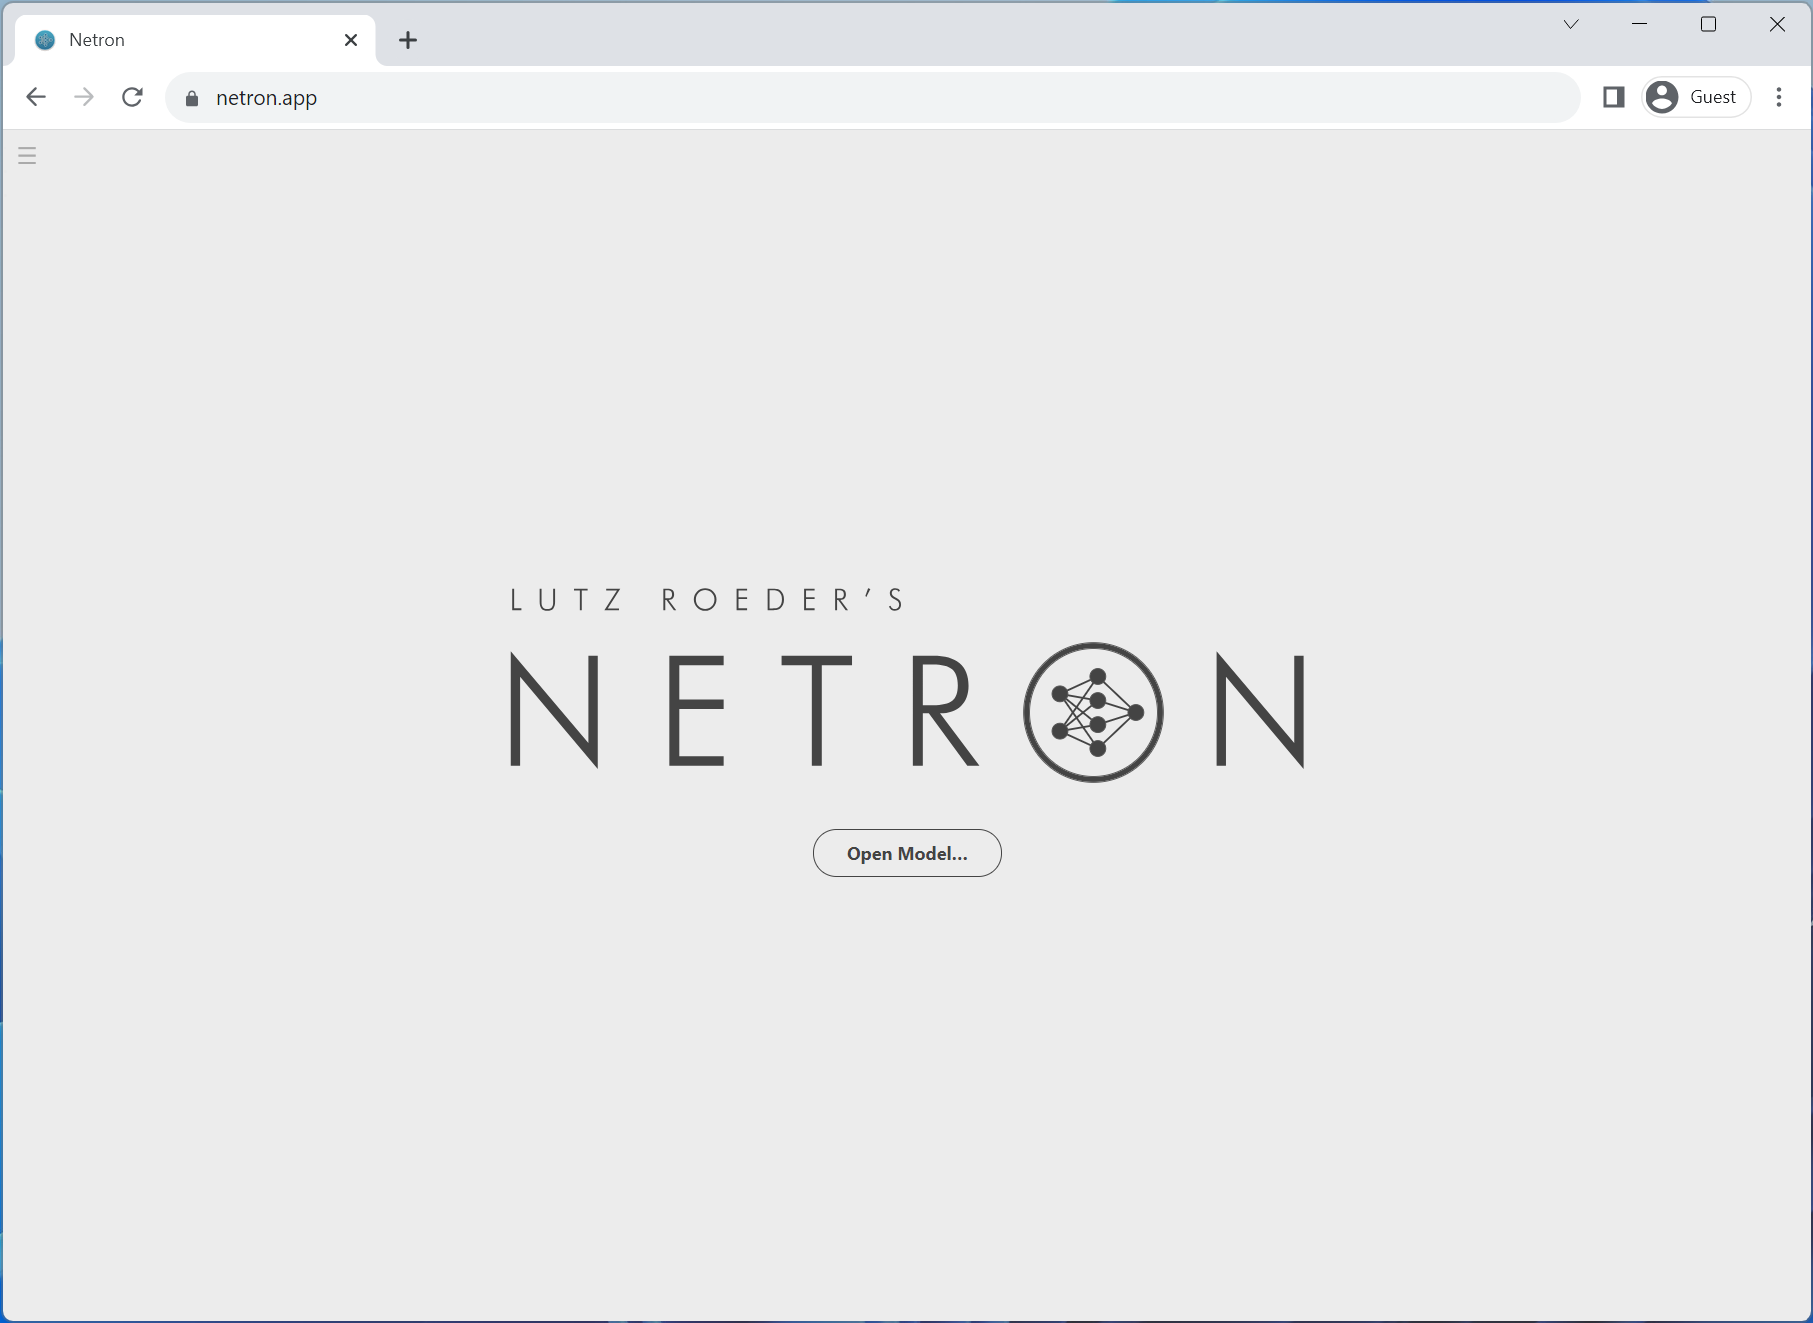

Once Netron is open, we can drag and drop our image_classifier_model.onnx file into the browser or select it after clicking the Open model button.

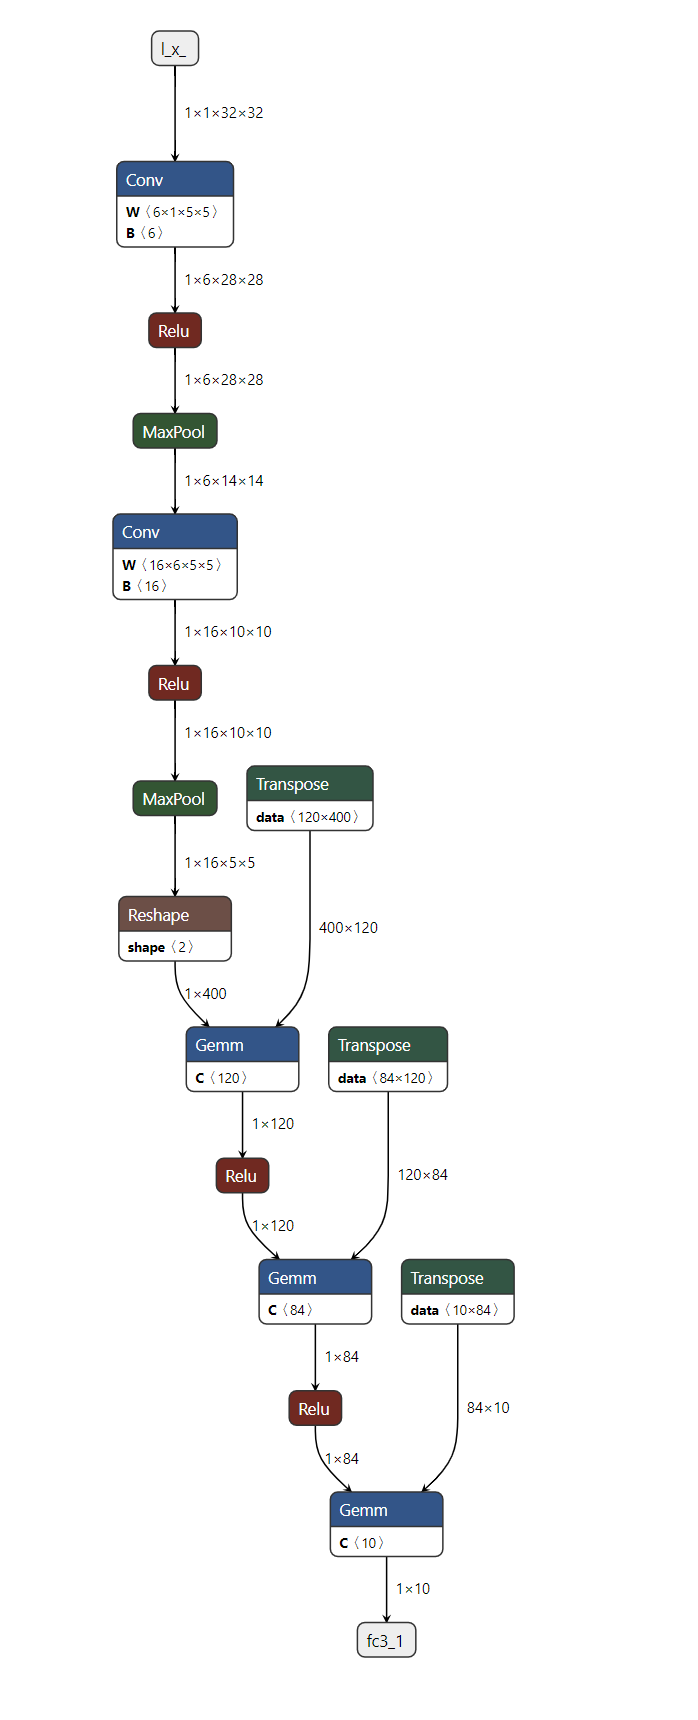

And that is it! We have successfully exported our PyTorch model to ONNX format and visualized it with Netron.

## 6. Execute the ONNX model with ONNX Runtime
The last step is executing the ONNX model with ONNX Runtime, but before we do that, let’s install ONNX Runtime.

In [ ]:
pip install onnxruntime

The ONNX standard does not support all the data structure and types that PyTorch does, so we need to adapt PyTorch input’s to ONNX format before feeding it to ONNX Runtime. In our example, the input happens to be the same, but it might have more inputs than the original PyTorch model in more complex models.

ONNX Runtime requires an additional step that involves converting all PyTorch tensors to Numpy (in CPU) and wrap them on a dictionary with keys being a string with the input name as key and the numpy tensor as the value.

Now we can create an ONNX Runtime Inference Session, execute the ONNX model with the processed input and get the output. In this tutorial, ONNX Runtime is executed on CPU, but it could be executed on GPU as well.

In [5]:
import onnxruntime

onnx_inputs = [tensor.numpy(force=True) for tensor in example_inputs]
print(f"Input length: {len(onnx_inputs)}")
print(f"Sample input: {onnx_inputs}")

ort_session = onnxruntime.InferenceSession(
    "./image_classifier_model.onnx", providers=["CPUExecutionProvider"]
)

onnxruntime_input = {input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), onnx_inputs)}

# ONNX Runtime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [array([[[[-2.424365  ,  0.12442707, -1.3106309 , ..., -0.00958968,
           0.45586714, -0.06486795],
         [ 1.0653884 ,  1.2942584 , -0.5174472 , ...,  1.3976389 ,
          -0.58531255, -0.7141052 ],
         [-1.1675946 ,  0.3087384 , -0.00423703, ..., -1.7597266 ,
          -0.02708087, -0.20430915],
         ...,
         [-0.7496035 , -0.7580035 , -1.1580011 , ..., -1.4559826 ,
          -0.2592231 , -1.854857  ],
         [ 0.31866682,  0.9717696 ,  1.7043965 , ...,  0.98929507,
          -0.29359162,  1.2024976 ],
         [-0.8769791 , -0.18754688,  3.0218697 , ...,  1.3396285 ,
          -0.83350086, -0.5183962 ]]]],
      shape=(1, 1, 32, 32), dtype=float32)]


## 7. Compare the PyTorch results with the ones from the ONNX Runtime
The best way to determine whether the exported model is looking good is through numerical evaluation against PyTorch, which is our source of truth.

For that, we need to execute the PyTorch model with the same input and compare the results with ONNX Runtime’s. Before comparing the results, we need to convert the PyTorch’s output to match ONNX’s format.


In [6]:
torch_outputs = torch_model(*example_inputs)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [[-0.03809328  0.06662077  0.04762337  0.06125492 -0.01635434  0.06162105
  -0.11453653 -0.02026426 -0.03008296  0.00081813]]


## Conclusion
That is about it! We have successfully exported our PyTorch model to ONNX format, saved the model to disk, viewed it using Netron, executed it with ONNX Runtime and finally compared its numerical results with PyTorch’s.

## Further reading
The list below refers to tutorials that ranges from basic examples to advanced scenarios, not necessarily in the order they are listed. Feel free to jump directly to specific topics of your interest or sit tight and have fun going through all of them to learn all there is about the ONNX exporter.

1. Exporting a PyTorch model to ONNX
2. Extending the ONNX exporter operator support
3. Export a model with control flow to ONNX